In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

In [2]:
# Import the data
data = np.loadtxt("gmm_data_f23.txt", dtype=float) 

#### Part A:
Assuming that Σi = σi2I, compute and write below the means μ1,μ2,μ3 and the standard deviations σ1,σ2,σ3. We highly recommend that you use the GaussianMixture model from sklearn. (Please use random initialization for this part, with random seed as 200 and a default convergence thresh- old/tolerance of 0.001)

In [3]:
gm = GaussianMixture(n_components=3, random_state=200, covariance_type='spherical',tol=0.001).fit(data)

In [4]:
# means are:
means = gm.means_
for i in range(len(means)):
    print(f"For cluster, {i+1}, the means are: {means[i]}")

For cluster, 1, the means are: [-0.0019703   0.00120194 -0.00121744  0.00904807 -0.01300412]
For cluster, 2, the means are: [ 2.98998279 -3.95741665  5.02328866 -5.9296063   6.99524544]
For cluster, 3, the means are: [-3.07239091  3.98605217 -4.96665248  6.0373098  -6.92928605]


In [5]:
# to get standard deviation:
covariance = gm.covariances_
standard_deviations = np.sqrt(covariance)
for i in range(len(standard_deviations)):
    print(f"For cluser, {i + 1}, the standard deviation is: {standard_deviations[i]}")

For cluser, 1, the standard deviation is: 0.24860052345078323
For cluser, 2, the standard deviation is: 1.002101350124038
For cluser, 3, the standard deviation is: 1.001859467994668


#### Part B:
From these computed means and std. deviations, cluster all the 3000 points, and plot three figures\
– Plot the first two dimensions (xi1,xi2) with their cluster assignments.\
– Plot the third and fourth dimensions (xi3,xi4) with their cluster assignments.\
– Plot the fourth and fifth dimensions (xi4,xi5) with their cluster assignments.

In [6]:
predicted_clusters = gm.predict(data)

In [7]:
predicted_clusters = ["#2522d6" if x == 2 else x for x in predicted_clusters]
predicted_clusters = ["#0e7318" if x == 0 else x for x in predicted_clusters]
predicted_clusters = ["#ed0c0c" if x == 1 else x for x in predicted_clusters]

Text(0.5, 1.0, 'xi1 and xi2 cluster assignments')

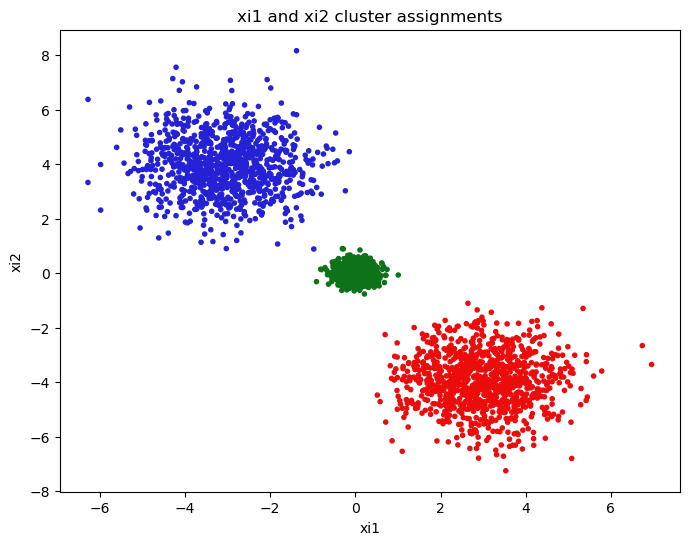

In [8]:
# Plotting first 2 dimensions
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=predicted_clusters, marker='.')
plt.xlabel('xi1')
plt.ylabel('xi2')
plt.title("xi1 and xi2 cluster assignments")

Text(0.5, 1.0, 'xi3 and xi4 cluster assignments')

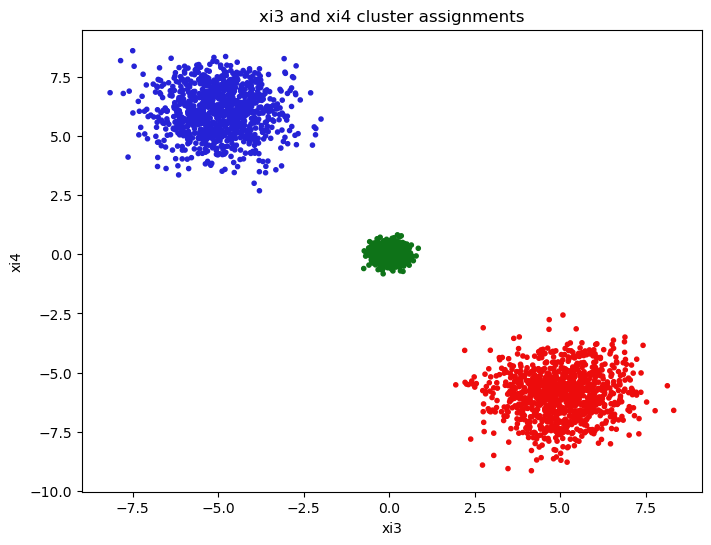

In [9]:
# Plotting xi3 and xi4 dimensions
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 2], data[:, 3], c=predicted_clusters, marker='.')
plt.xlabel('xi3')
plt.ylabel('xi4')
plt.title("xi3 and xi4 cluster assignments")

Text(0.5, 1.0, 'xi4 and xi5 cluster assignments')

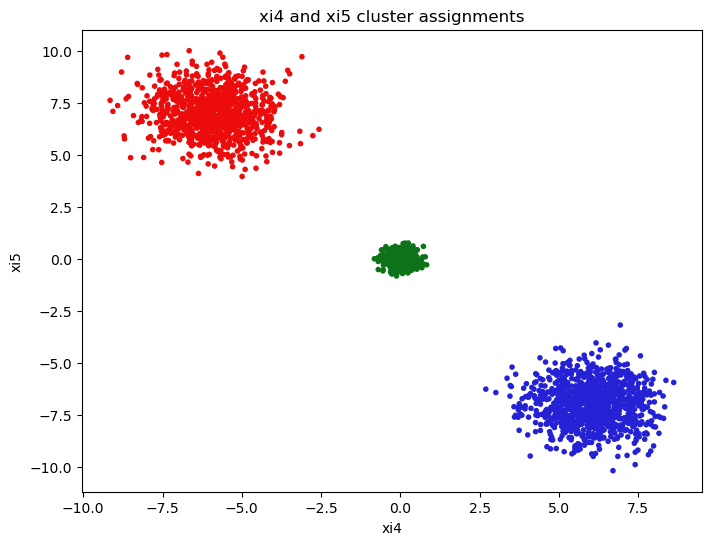

In [10]:
# Plotting xi4 and xi5 dimensions
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 3], data[:, 4], c=predicted_clusters, marker='.')
plt.xlabel('xi4')
plt.ylabel('xi5')
plt.title("xi4 and xi5 cluster assignments")

#### Part C:
For this subquestion, you are not permitted to use any library function that performs the EM algorithm, and you are instead supposed to write your own EM algorithm to estimate the means μ1,μ2,μ3. You can assume that values of π1 , π2 , π3 and σ1 , σ2 , σ3 are known and reuse the values that you computed in part (a) (They can be found in GaussianMixture.weights_ and GaussianMixture.covariances_). Write down your E step and M step to estimate μ1,μ2,μ3. For the programming, please use a convergence threshold/tolerance of 0.001.

In [11]:
n,d = data.shape

# initialization
means = np.random.rand(3,d)
covariances = gm.covariances_
mixed_prob = gm.weights_

In [12]:
def multivariate_normal_arti(data, mean, sd):
    k = mean.shape[0]
    exponent = -0.5 * ((data - mean) @ np.linalg.inv(sd) * (data-mean))
    other_term = 1 / (np.sqrt((2*np.pi)**k * np.linalg.det(sd)))
    return other_term * exponent
    

In [13]:
# Expectation Step 
# The expectation step is estimating the values of rnk = p(zn=k | xn) -> instead of a one-hot vector, this will be a vector of the probabilities that the point belongs to a certain cluster
def expectation(data, means, covariances, mixed_prob):
    rnks = np.zeros((n,len(covariances))) #3000x3
    denom = np.zeros((n, 1)) # 3000x1
    
    for c in range(len(covariances)): # for each cluster
        numerator = multivariate_normal_arti(data, mean=means[c], sd=covariances[c]) * mixed_prob[c]
        rnks[:, c] = numerator
        denom += numerator.reshape(-1, 1)
    
    rnks/=denom
    return rnks

In [14]:
# the maximization step is just for updating the means
def maximization(data, rnks):
    final_means = np.zeros((3, 5))
    for c in range(3):
        rnk_for_all_data = rnks[:,c] # getting the rnk for all the x's per cluster
        sum_rnk = np.sum(rnk_for_all_data)
        
        inside_sum = rnk_for_all_data.reshape(-1, 1) * data
        inside_sum = np.sum(inside_sum, axis=0) # summing across each column -> will give [1x5]
        
        final_means[c] = inside_sum / sum_rnk
    return final_means

In [15]:
# The loss is the sum of log of denom of ranks
def calculate_log_loss(data, means, covariances, mixed_prob):
    denom = np.zeros((n, 1)) # 3000x1
    
    for c in range(len(covariances)): # for each cluster
        numerator = multivariate_normal_arti(data, mean=means[c], sd=covariances[c]) * mixed_prob[c]
        denom += numerator.reshape(-1, 1)
        
    log_denom = np.log(denom)
    return np.sum(log_denom, axis=0)[0]

In [16]:
# Iteration for the EM Algorithm
for iter in range(100):
    old_log_loss = calculate_log_loss(data, means, covariances, mixed_prob)
    rnks = expectation(data, means, covariances, mixed_prob)
    means = maximization(data, rnks)
    new_log_loss = calculate_log_loss(data, means, covariances, mixed_prob)
    
    # Checking for covergence
    if np.abs(old_log_loss-new_log_loss) < 0.001:
        break
    old_log_loss=new_log_loss

In [17]:
for mean in range(len(means)):
    print(f"For cluster {mean}, the means are: {means[mean]}")

For cluster 0, the means are: [-0.0019703   0.00120194 -0.00121744  0.00904807 -0.01300412]
For cluster 1, the means are: [ 2.98998279 -3.95741665  5.02328866 -5.9296063   6.99524544]
For cluster 2, the means are: [-3.07239091  3.98605217 -4.96665248  6.0373098  -6.92928605]


#### Part D:
We now relax the assumption that π1,π2,π3 are known. Modify your EM algorithm to simultaneously estimate means μ1, μ2, μ3 and the component probabilities π1, π2, π3. You can still assume that σ1, σ2 and σ3 are known and use their values from the solution above. Write down your E step and M step. For the programming, please use convergence threshold/tolerance of 0.001. For this part too, you are not permitted to use library functions that perform EM algorithm.

In [18]:
# initialization
means = np.random.rand(3,d)
covariances = gm.covariances_
mixed_prob = np.random.rand(3,1)

In [19]:
def maximization_2(data, rnks):
    final_means = np.zeros((3, 5))
    for c in range(3):
        rnk_for_all_data = rnks[:,c] # getting the rnk for all the x's per cluster
        sum_rnk = np.sum(rnk_for_all_data)
        
        inside_sum = rnk_for_all_data.reshape(-1, 1) * data
        inside_sum = np.sum(inside_sum, axis=0) # summing across each column -> will give [1x5]
        
        final_means[c] = inside_sum / sum_rnk
        
    all_nums = np.sum(rnks, axis=0) # sum across columns -> 1x3
    denom = np.sum(all_nums)
    final_weights = all_nums/denom
        
    return final_means, final_weights

In [20]:
# Iteration for the EM Algorithm
for iter in range(100):
    old_log_loss = calculate_log_loss(data, means, covariances, mixed_prob)
    rnks = expectation(data, means, covariances, mixed_prob)
    means, mixed_prob = maximization_2(data, rnks)
    new_log_loss = calculate_log_loss(data, means, covariances, mixed_prob)
    
    # Checking for covergence
    if np.abs(old_log_loss-new_log_loss) < 0.001:
        break
    old_log_loss=new_log_loss

In [21]:
for mean in range(len(means)):
    print(f"For cluster {mean}, the means are: {means[mean]}")
    
for weight in range(len(mixed_prob)):
    print(f"For cluster {weight}, the means are: {mixed_prob[weight]}")

For cluster 0, the means are: [-0.0019703   0.00120194 -0.00121744  0.00904807 -0.01300412]
For cluster 1, the means are: [ 2.98998279 -3.95741665  5.02328866 -5.9296063   6.99524544]
For cluster 2, the means are: [-3.07239091  3.98605217 -4.96665248  6.0373098  -6.92928605]
For cluster 0, the means are: 0.3333333333333333
For cluster 1, the means are: 0.3333333333333333
For cluster 2, the means are: 0.3333333333333333
